In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression

## Problem 2: Brownian Motion and the Diffusion Equation.

The equation governing the brownian motion of a particle is a stochastic differential equation of the form 
$$dX = vdt + \gamma dW$$
Where X is the position of the particle, v is the drift velocity, and dW is the Wiener process randomly sampled from  a Gaussian of 0 mean and standard deviation of dt, where dt is the infitesimal time step.

a.)

In order to generate a time series of the positions of the Brownian particles, we discretize our stochastic differential equation, such that
$$X(t+ \Delta t ) = X(t) + v \Delta t + \gamma \mathcal{N}(0, \Delta t) $$
and fix the paramters and initial condition $v = 0.03, \gamma = 0.1,$ and X(0) = 0.

We discretize the time array into 2000 steps such that the final time is $t_f = 50$ and generate time series for 2000 brownian particles.

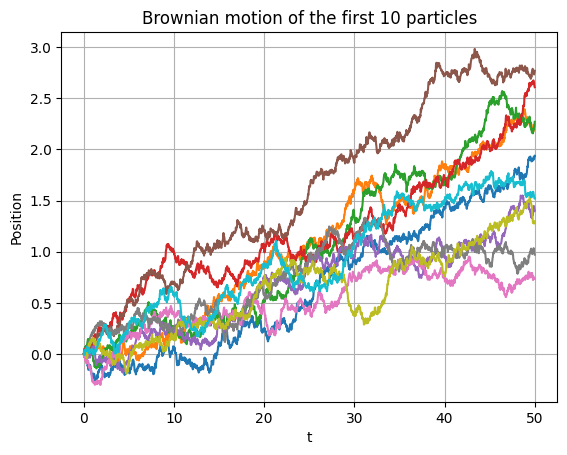

In [39]:
v = 0.03
gamma = 0.1
dt = 50/2000
t = np.linspace(0, 50, 2000)
positions = np.zeros((2000, 2000))
for i in range(2000 - 1):
    N = np.random.normal(0, np.sqrt(dt), 2000)
    positions[:, i + 1] = positions[:, i] + v * dt + gamma*N

for i in range(10):
    plt.plot(t, positions[i])
plt.xlabel('t')
plt.ylabel('Position')
plt.title('Brownian motion of the first 10 particles')
plt.grid()
plt.show()

We notice that these random walks the particles are undergoing are directed in a sence that there is a prefered direction these random walk are tending to. This is because of the introduction of the drift term that introduces bulk motion in the collection of the particles.<br>
The size of this generated time series was enough for us to notice that but it would look clearer for longer time series.

b.)

We take a sample of the spatial variable (from -1 to 2.5) and specify instances in time to find the distribution of the random brownian positions of our particles at these time instances. We then generate smooth Gaussian Kernel density estimations of these distributions.

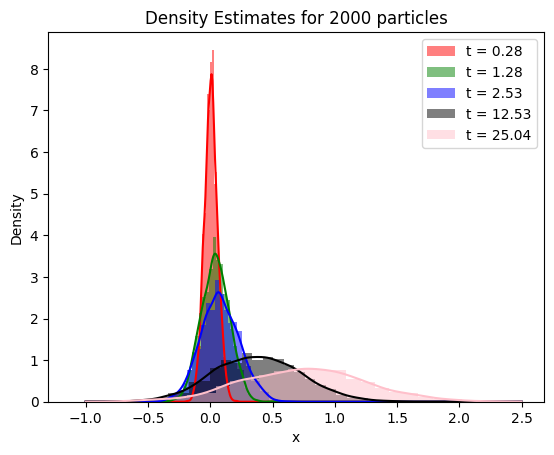

(1999, 500)


In [3]:
indices = [10, 50, 100, 500, 1000]
positions = np.delete(positions, 0, 1)
t = t[1:]
colors = ['r', 'g', 'b', 'k', 'pink']
x_vals = np.linspace(-1, 2.5, 500)
x_kde_vals = np.zeros((len(t), len(x_vals)))
for i in range(len(t)):
    kde = gaussian_kde(positions[:, i])
    x_kde_vals[i, :] = kde(x_vals)

fig, ax = plt.subplots()
for i, index in enumerate(indices):
    ax.hist(positions[:, index], bins=30, alpha=0.5, density=True, color=colors[i], label=f't = {t[index]:.2f}')
for i, index in enumerate(indices):
    ax.plot(x_vals, x_kde_vals[index, :], color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Density Estimates for 2000 particles')
ax.legend()
plt.show()
print(x_kde_vals.shape)

Increasing the number of particles to 10000, keeping the number of time steps the same, would lead to a more accurate estimation of the underlying probability density function (PDF) using the Gaussian KDE function.
By plotting these new distributions, we notice how the histograms are taking the shape of the smooth curve above them snd how the PDF becomes less sensitive to random fluctuations inherent in the sample.


The bandwidth parameter in Kernel Density Estimation (KDE) controls the smoothness of the estimated probability density function (PDF). A smaller bandwidth results in a more flexible, detailed PDF, while a larger bandwidth leads to a smoother, more generalized PDF

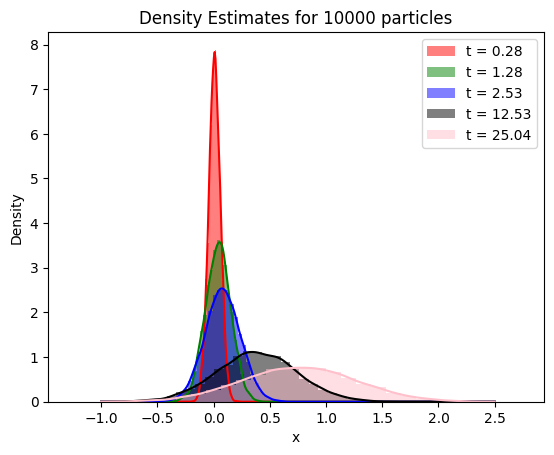

(1999, 500)


In [4]:
positions_ = np.zeros((10000, 2000))
for i in range(2000 - 1):
    N = np.random.normal(0, np.sqrt(dt), 10000)
    positions_[:, i + 1] = positions_[:, i] + v * dt + gamma*N
positions_ = np.delete(positions_, 0, 1)
x_kde_vals_ = np.zeros((len(t), len(x_vals)))
for i in range(len(t)):
    kde = gaussian_kde(positions_[:, i])
    x_kde_vals_[i, :] = kde(x_vals)

fig, ax = plt.subplots()
for i, index in enumerate(indices):
    ax.hist(positions_[:, index], bins=30, alpha=0.5, density=True, color=colors[i], label=f't = {t[index]:.2f}')
for i, index in enumerate(indices):
    ax.plot(x_vals, x_kde_vals_[index, :], color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Density Estimates for 10000 particles')
ax.legend()
plt.show()
print(x_kde_vals_.shape)

c.)

The KDE data are stored in a matrix where the each column represent the spacial values at different time instances:
$$\begin{pmatrix}
P_{t_0}^{x_0} & P_{t_0}^{x_1} & P_{t_0}^{x_2} & \dots \\\\
P_{t_1}^{x_0} & P_{t_1}^{x_1} & P_{t_1}^{x_2} & \dots \\\\
P_{t_2}^{x_0} & P_{t_2}^{x_1} & P_{t_2}^{x_2} & \dots \\\\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}$$

To find the first and second discrete spatial derivatives and the first discrete temperol derivative, we will approximate them up to the first and second orders in the correponding Taylor expansions.<br> we would need 2 nested loops; fixing a row, we loop over the columns (ignoring the last 2 columns) we find the spatial derivative. And we need 2 consecutive rows to find the corresponding temporal derivative such that
$$\frac{\partial p}{\partial x }(j,i)= \frac{p^{i+1}_j - p^{i}_j}{\Delta x} $$
$$\frac{\partial^2 p}{\partial x^2 }(j,i)= \frac{p^{i+1}_j - 2p^{i}_j + p^{i-1}_j}{\Delta x^2} $$
$$\frac{\partial p}{\partial t}(j,i)= \frac{p^{i}_{j+1} - p^{i}_j}{\Delta t} $$
<br>
We store all the values of these derivatives in 1d arrays and use the first and second spatial derivatives vectors as the columns of our feature matrix and the temporal derivative vector as our output vector.<br>
The goal is to fit the advection-diffusion equation

$$\frac{\partial p}{\partial t} = a \frac{\partial p}{\partial x} + b\frac{\partial^2 p}{\partial x^2}$$

In [40]:
dp_dx = []
d2p_dx = []
dp_dt = []
dx = x_vals[1] - x_vals[0]
dt = t[1] - t[0]
for j in range(len(x_kde_vals[:,0]) - 1):
    for i in range(1, len(x_kde_vals[0]) - 1):
        dp_dx.append((x_kde_vals[j,i+1] - x_kde_vals[j, i])/(dx))
        d2p_dx.append((x_kde_vals[j,i+1] - 2*x_kde_vals[j, i] + x_kde_vals[j, i-1])/dx**2)
        dp_dt.append((x_kde_vals[j+1, i] - x_kde_vals[j, i])/dt)

dp_dt = np.array(dp_dt)
dp_dx = np.array(dp_dx)
d2p_dx = np.array(d2p_dx)

phi = np.array([dp_dx, d2p_dx]).T
y = dp_dt.T
reg = LinearRegression()
fit = reg.fit(phi, y)
coef = reg.coef_
score = reg.score(phi, y)
print("a =", coef[0], "\nb =", coef[1])
print("score =", score)

a = -0.01200190846908537 
b = 0.0028151787264233405
score = 0.7296729469843234


d.)

The Advection-Diffusion equation is given by
$$\frac{\partial p}{\partial t} = a \frac{\partial p}{\partial x} + b\frac{\partial^2 p}{\partial x^2}$$
We can discretize this equation and transform the problem of solving for p(x,t) to an iterative problem.
$$p[t_{j+1}, x_i] = p[t_j, x_i] + a\frac{\Delta t}{\Delta x} \left( p[t_j, x_{i+1}] - p[t_j, x_{i}] \right) + b \frac{\Delta t}{(\Delta x)^2} \left( p[t_j, x_{i+1}] - 2p[t_j, x_j] + p[t_j, x_{i-1}] \right) $$

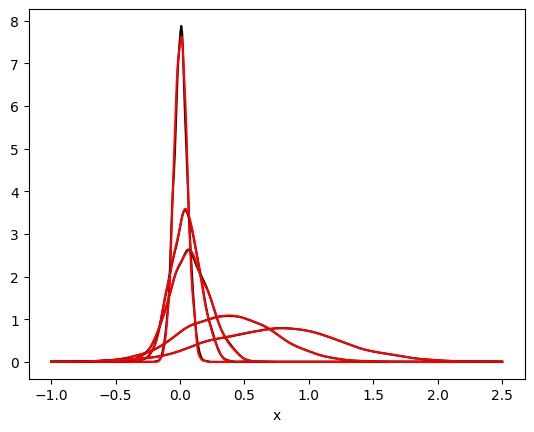

In [54]:
a = coef[0]
b = coef[1]

p = np.zeros(len(dp_dx))

p = np.zeros((len(x_kde_vals[:,0]), len(x_kde_vals[0])))
p[0,0] = x_kde_vals[0,0]
for j in range(len(x_kde_vals[:,0])-1):
    for i in range(1, len(x_kde_vals[0]) -1):
        p[j+1, i] = x_kde_vals[j,i] + (a*dt)/(dx) * (x_kde_vals[j, i+1] - x_kde_vals[j,i]) + (b*dt)/(dx*2) * (x_kde_vals[j, i+1] - 2*x_kde_vals[j,i] + x_kde_vals[j,i-1])

fig, ax = plt.subplots()
for i, index in enumerate(indices):
    ax.plot(x_vals, x_kde_vals[index, :], color='k')
    ax.plot(x_vals, p[index, :], color='r')
    
ax.set_xlabel('x')
plt.show()

The red plots are the ones we get by solving the advection-diffusion equation and the black plot are the ones corresponding to the KDE data.

e.)

Comparing the discretized advection-diffusion equation with the discretized stochastic equation of brownian motion:
$$p[t_{j+1}, x_i] = p[t_j, x_i] + \frac{a \Delta p }{\Delta x} \Delta t + \frac{b}{(\Delta x)^2} \Delta^2p \; \Delta t$$
$$X(t+ \Delta t ) = X(t) + v \Delta t + \gamma dW $$

In the advection-diffusion equation: a represents the advection coefficient, which determines the rate at which the variable is advected. And b represents the diffusion coefficient that determines the rate of diffusion of the variable due to random motion.<br>
In the discretized SDE describing the brownian motion: $v$ represents the advection velocity and $\gamma$ represents the stochastic diffusion coefficient determining the randomness in the particle's movement over time.<br>
Hence, we can deduce that the pairs (a, $v$) and (b, $\gamma$) are related and play similiar roles in their corresponding equations.

(to be revisited)